# Run The Agent on Mountain Car

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import gym

import pandas as pd

In [2]:
from vae_recurrent import VAE, create_decoder, create_encoder
from transition_gru import TransitionGRU
from recurrent_agent import DAIFAgentRecurrent
from prior_model import PriorModelBellman
from habitual_action_network import HabitualAction, compute_discounted_cumulative_reward
from ddpg import *

In [3]:
from util import random_observation_sequence, transform_observations, test_policy, habit_policy
from train_agent import train_single_agent

In [4]:
# from identity_vae import IdentityVAE, identity_encoder, identity_decoder

What does the agent do?
- The agent plans using a policy then executes that policy for 12 simulation timesteps, the first two actions of the policy are executed for 6 steps each

What data does it accumulate?
- It accumulates 12 observation actions pairs

How is it trained?
- VAE is trained to reproduce observations using the latent states
- Transition is trained by taking previous hidden state and previous latent state and trying to predict the next latent state


Online learning For all tasks, we initialize all the agents with random weights and learn online only. Training an agent for 150 epochs takes about 3 minutes on a single CPU core (Intel I7-4870HQ). In contrast, previous approaches using active inference [Ueltzhöffer, 2018, Tschantz et al., 2019, 2020] and policy gradient methods (e.g., [Liu et al., 2017]) use (offline) policy replay and typically need hours of GPU-accelerated compute while achieving similar convergence. To our knowledge, this is the first model-based RL method to learn online using neural network representations. This is afforded by the high sample efficiency of the FEEF, which directs exploration towards states that are uncertain for both the encoder and transition models.


Why this is true?

In [5]:
# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

## Test with no prior model FEEF

In [13]:
def test_policy(env, policy_func, observation_max, observation_min, obs_stddev, num_episodes, num_action_repeats, show_env=False):

    all_rewards = []
    all_times = []
    all_num_actions = []

    rows = []

    for i in range(num_episodes):

        obs = env.reset()

        if show_env:
            env.render()

        done = False
        rewards = []
        t = 0

        while not done:

            obs = obs.reshape(1, obs.shape[0])
            obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

            action = policy_func(obs)
            action = action.numpy()
            print(action)

            for k in range(num_action_repeats):
                obs, reward, done, info = env.step(action)

                t += 1

                if show_env:
                    env.render()

            rewards.append(reward)

        rows.append([np.sum(rewards), t, t//num_action_repeats])
        # all_rewards.append(np.sum(rewards))
        # all_times.append(t)
        # all_num_actions.append(t//num_action_repeats)

    env.close()

    results = pd.DataFrame(rows, columns=["reward", "timesteps", "num_actions"])

    return results

In [23]:
pln_hrzn = 5
latent_dim = 2
obs_dim = 3

# make the VAE
enc = create_encoder(obs_dim, latent_dim, [20])
dec = create_decoder(latent_dim, obs_dim, [20])
vae = VAE(enc, dec, latent_dim,  [0]*latent_dim, [0.3]*latent_dim, train_epochs=2, show_training=True)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# make the TRANSITION
tran = TransitionGRU(latent_dim, 1, 2*pln_hrzn*latent_dim, 2, train_epochs=2, show_training=True)
tran.compile(optimizer=tf.keras.optimizers.Adam())

# make the HABIT ACTION NET
habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=False)
habit_net.compile(optimizer=tf.keras.optimizers.Adam())

# # # make the HABIT ACTION NET
# actor_model = get_actor(2, 1)
# critic_model = get_critic(2, 1)
# target_actor = get_actor(2, 1)
# target_critic = get_critic(2, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)


# make the PRIOR NET
prior_model = PriorModelBellman(latent_dim, output_dim=1, scaling_factor=0.01, show_training=False, use_tanh_on_output=False)

# unscaled prior mean and prior stddev
prior_mean = [0, 0, 0]
prior_stddev = [1, 1, 1]

observation_max = np.array([1, 1, 8])
observation_min = np.array([-1, -1, -8])

# observation_noise_stddev = [0, 0]
observation_noise_stddev = [0.05, 0.05, 0.05]

scaled_prior_mean = transform_observations(prior_mean, observation_max, observation_min, [0,0,0])  # no noise on prior

In [24]:
daifa = DAIFAgentRecurrent(prior_model,
                           vae,
                           tran,
                           habit_net,
                           planning_horizon=pln_hrzn,
                           use_kl_extrinsic=True,  # maybe this works
                           use_kl_intrinsic=True,
                           use_FEEF=False,
                           train_habit_net=True,
                           train_prior_model=True,
                           train_tran=True,
                           train_after_exploring=True,
                           train_with_replay=True,
                           use_fast_thinking=True,
                           habit_model_type="PG",
                           uncertainty_tolerance=0.1,
                           min_rewards_needed_to_train_prior=-30)


daifa.train_prior = True
daifa.prior_model.show_training = False

In [25]:
env = gym.make("Pendulum-v1")
env.action_space.sample()

array([-0.8265499], dtype=float32)

In [26]:
# train the agent on the env
env = gym.make("Pendulum-v1")
daifa, results_one = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=60, render_env=False)

Episode 1
[ 0.4638155  -0.8859318  -0.06816371]
fast thinking
Epoch 1/2
1/1 [==============================] - 1s 539ms/step - kl_loss: 0.2754
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.2663
Epoch 1/2
1/1 [==============================] - 0s 195ms/step - loss: 324.1006 - reconstruction_loss: 315.5265 - kl_loss: 8.5741
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: 387.2435 - reconstruction_loss: 378.7694 - kl_loss: 8.4741
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.2898
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.2828
Epoch 1/2
1/1 [==============================] - 0s 1ms/step - loss: 245.9514 - reconstruction_loss: 232.8542 - kl_loss: 13.0972
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - loss: 173.9973 - reconstruction_loss: 161.0199 - kl_loss: 12.9774
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.4673
Epoch 2/2
1/1 [==========

In [27]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

[[-0.9999847]]
[[-0.99998605]]
[[-0.9999225]]
[[0.788844]]
[[-0.24475694]]
[[-0.9998107]]
[[-0.9997041]]
[[0.8476998]]
[[0.98380876]]
[[-0.9971517]]
[[-0.99813217]]
[[0.64551556]]
[[0.4988195]]
[[-0.9986258]]
[[-0.99775445]]
[[0.99499846]]
[[-0.72516656]]
[[-0.99972457]]
[[-0.99950093]]
[[-0.25013044]]
[[0.93849057]]
[[-0.9979411]]
[[-0.99878967]]
[[0.9952538]]
[[0.7131172]]
[[-0.99540454]]
[[-0.48355168]]
[[0.95396745]]
[[-0.94364625]]
[[-0.96951824]]
[[0.9957447]]
[[0.10688989]]
[[-0.9665973]]
[[0.49411416]]
[[0.97614944]]
[[0.97789913]]
[[0.9827886]]
[[0.98413116]]
[[0.99011475]]
[[0.9828187]]
[[0.97657555]]
[[0.98228425]]
[[0.9653112]]
[[0.9875387]]
[[0.9883943]]
[[0.9793135]]
[[0.9781578]]
[[0.9630074]]
[[0.9763142]]
[[0.99007535]]
[[0.9842757]]
[[0.9721533]]
[[0.9821666]]
[[0.9814092]]
[[0.98306584]]
[[0.99023795]]
[[0.9791569]]
[[0.9788779]]
[[0.9795013]]
[[0.9768523]]
[[0.98871064]]
[[0.98828876]]
[[0.97850287]]
[[0.9802462]]
[[0.98008794]]
[[0.98008466]]
[[0.98812616]]
[[0.979

,reward,timesteps,num_actions
0,-174.290924,204,34
1,-264.419006,204,34
2,-264.804138,204,34
3,-208.613525,204,34
4,-208.576080,204,34
5,-201.111496,204,34
6,-170.493958,204,34
7,-208.788696,204,34
8,-288.000275,204,34
9,-180.362473,204,34


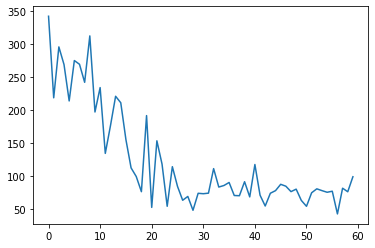

In [28]:
plt.plot(results_one.VFE_post_run)

In [29]:
daifa.train_vae = False
daifa.model_vae.show_training = False

In [30]:
# train the agent on the env
env = gym.make("Pendulum-v1")
daifa, results_two = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[0.09571323 0.99540895 0.4442995 ]
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.7121
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.7823
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 13.8400
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 14.1267
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 12.1174
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 11.8256
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 24.2671
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 24.1093
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 0.6156
Epoch 2/2
1/1 [==============================] - 0s 1ms/step - kl_loss: 0.5771
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 13.0265
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl

In [31]:
# # make the HABIT ACTION NET
# habit_net = HabitualAction(latent_dim, 1, [16, 16], train_epochs=2, show_training=True)
# habit_net.compile(optimizer=tf.keras.optimizers.Adam())
#
# daifa.habit_action_model = habit_net
#
# actor_model = get_actor(latent_dim, 1)
# critic_model = get_critic(latent_dim, 1)
#
# target_actor = get_actor(latent_dim, 1)
# target_critic = get_critic(latent_dim, 1)
#
# # Making the weights equal initially
# target_actor.set_weights(actor_model.get_weights())
# target_critic.set_weights(critic_model.get_weights())
#
# critic_optimizer = tf.keras.optimizers.Adam(0.0001)
# actor_optimizer = tf.keras.optimizers.Adam(0.00005)
#
# habit_net = BasicDDPG(actor_model, critic_model, target_actor, target_critic, tau=0.005, critic_optimizer=critic_optimizer, actor_optimizer=actor_optimizer)

In [32]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

[[-0.9999956]]
[[-0.9999276]]
[[0.9717017]]
[[-0.9992425]]
[[-0.9999996]]
[[-0.9070271]]
[[0.9934823]]
[[-0.99998575]]
[[-0.9999999]]
[[-0.99995726]]
[[0.96853244]]
[[-0.99973077]]
[[-0.9999995]]
[[-0.9987053]]
[[0.99550587]]
[[-0.99998015]]
[[-1.]]
[[-1.]]
[[-0.9999598]]
[[0.9614532]]
[[-0.99989307]]
[[-1.]]
[[-0.99993795]]
[[0.99822277]]
[[-0.999492]]
[[-1.]]
[[-1.]]
[[-1.]]
[[-0.9999989]]
[[0.08209892]]
[[-0.9147555]]
[[-0.9999975]]
[[-0.9926654]]
[[0.99749386]]
[[-1.]]
[[-1.]]
[[-1.]]
[[-0.99980557]]
[[0.997134]]
[[-0.9999912]]
[[-1.]]
[[-1.]]
[[-0.9999996]]
[[0.9968242]]
[[-0.9182594]]
[[-1.]]
[[-1.]]
[[-0.9999851]]
[[0.9980948]]
[[-0.9999706]]
[[-1.]]
[[-1.]]
[[-1.]]
[[-1.]]
[[-0.99932474]]
[[0.9721099]]
[[-0.9999932]]
[[-0.9999997]]
[[-0.95777595]]
[[0.99579597]]
[[-0.9999931]]
[[-1.]]
[[-1.]]
[[-1.]]
[[0.98789483]]
[[0.7865886]]
[[-0.9999995]]
[[-0.9999993]]
[[-0.99999934]]
[[-0.39880198]]
[[0.98633057]]
[[-0.99997514]]
[[-0.9999986]]
[[-0.9910445]]
[[0.9718688]]
[[-0.99998194]

,reward,timesteps,num_actions
0,-162.710556,204,34
1,-129.821579,204,34
2,-196.523254,204,34
3,-197.150375,204,34
4,-128.037262,204,34
5,-293.907532,204,34
6,-204.023666,204,34
7,-294.456818,204,34
8,-203.279236,204,34
9,-161.626801,204,34


In [35]:
daifa.habit_action_model.show_training = False
daifa.train_habit_net = True
daifa.train_after_exploring = True
daifa.use_kl_intrinsic = True
daifa.use_kl_extrinsic = False
daifa.use_fast_thinking = True
daifa.uncertainty_tolerance = 0.1

# daifa.tran.show_training = False
# daifa.prior_model.show_training = False

# train the agent on the env
env = gym.make("Pendulum-v1")
daifa, results_three = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=20, render_env=False)

Episode 1
[-0.89174557 -0.45253718  0.61515385]
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 5ms/step - kl_loss: 3.2820
Epoch 2/2
1/1 [==============================] - 0s 5ms/step - kl_loss: 3.1470
fast thinking
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 3.6299
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 3.3905
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 4.0633
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 4.2329
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 7.9514
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 7.6656
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.7031
Epoch 2/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.5802
Epoch 1/2
1/1 [==============================] - 0s 2ms/step - kl_loss: 6.3105
Epoch 2/2
1/1 [==============================] - 0s 2ms

In [36]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

[[-1.]]
[[-1.]]
[[-0.999985]]
[[0.9926074]]
[[-0.9981063]]
[[-1.]]
[[-1.]]
[[0.9902263]]
[[0.999153]]
[[-0.54729325]]
[[0.9755413]]
[[0.98625594]]
[[-1.]]
[[-1.]]
[[-1.]]
[[0.9771793]]
[[0.99796736]]
[[-0.999193]]
[[-0.79554117]]
[[0.9970504]]
[[-0.9998214]]
[[-1.]]
[[-0.9998888]]
[[0.9999314]]
[[-0.7635011]]
[[-0.9999752]]
[[-0.9964315]]
[[0.9978376]]
[[-0.9988771]]
[[-1.]]
[[-0.99999243]]
[[0.9998726]]
[[0.68442297]]
[[-0.9985651]]
[[0.99958545]]
[[0.9990507]]
[[0.9783091]]
[[0.9758151]]
[[0.9989933]]
[[0.9995645]]
[[0.9992406]]
[[0.99772114]]
[[0.9308463]]
[[0.99699825]]
[[0.99951404]]
[[0.99964595]]
[[0.9987143]]
[[0.9928902]]
[[0.9639039]]
[[0.99847186]]
[[0.9995326]]
[[0.9993045]]
[[0.99661386]]
[[0.9250229]]
[[0.99763757]]
[[0.9996322]]
[[0.9996329]]
[[0.99928516]]
[[0.99206525]]
[[0.9459597]]
[[0.99830794]]
[[0.99966735]]
[[0.99920183]]
[[0.99802566]]
[[0.61554104]]
[[0.99144995]]
[[0.9989991]]
[[0.99962515]]
[[0.9994061]]
[[0.999137]]
[[0.99712974]]
[[0.9946602]]
[[0.999047]]


,reward,timesteps,num_actions
0,-163.611710,204,34
1,-267.267273,204,34
2,-287.636658,204,34
3,-179.181763,204,34
4,-174.783951,204,34
5,-163.229477,204,34
6,-291.205383,204,34
7,-205.403137,204,34
8,-174.532150,204,34
9,-238.689728,204,34


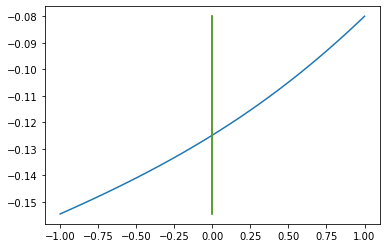

In [38]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

In [ ]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

utils = daifa.prior_model(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [ ]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(obs_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(obs_pos, utils)

In [ ]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T

latent_mean, _ , _ = daifa.model_vae.encoder(vel_pos)

# utils = daifa.habit_action_model.actor_model(latent_mean)
utils = daifa.select_fast_thinking_policy(latent_mean)
# print(utils)

plt.plot(vel_pos, utils)

In [43]:
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 5, daifa.agent_time_ratio, show_env=True)
res

[[-0.99992335]]
[[-0.88178855]]
[[0.99789256]]
[[-0.9998848]]
[[-1.]]
[[-0.9999769]]
[[0.99991107]]
[[-0.16730253]]
[[-0.9999739]]
[[-0.8034171]]
[[0.9970662]]
[[-0.9999894]]
[[-1.]]
[[-0.99990356]]
[[0.999879]]
[[-0.97488046]]
[[-0.9999994]]
[[-0.9999995]]
[[-0.9999298]]
[[0.99215883]]
[[-0.9951003]]
[[-1.]]
[[-1.]]
[[0.9989349]]
[[0.9983758]]
[[-0.966355]]
[[0.9603897]]
[[0.9575787]]
[[-1.]]
[[-1.]]
[[-1.]]
[[0.999734]]
[[0.9678278]]
[[-0.999788]]
[[0.99940175]]
[[0.99864036]]
[[0.9983579]]
[[0.9979407]]
[[0.9991464]]
[[0.99915755]]
[[0.99778235]]
[[0.9984719]]
[[0.99706304]]
[[0.998763]]
[[0.9988698]]
[[0.9993559]]
[[0.9990138]]
[[0.99794537]]
[[0.99839854]]
[[0.99911153]]
[[0.9989697]]
[[0.9992252]]
[[0.9982412]]
[[0.9965633]]
[[0.99803454]]
[[0.9994383]]
[[0.99928397]]
[[0.99822474]]
[[0.99837875]]
[[0.998344]]
[[0.9986446]]
[[0.99930716]]
[[0.9991316]]
[[0.9982009]]
[[0.9972399]]
[[0.9988507]]
[[0.9991977]]
[[0.9992266]]
[[0.7610545]]
[[0.99936944]]
[[0.9997359]]
[[0.9990438]]
[[

,reward,timesteps,num_actions
0,-163.081482,204,34
1,-295.807770,204,34
2,-253.660629,204,34
3,-202.541702,204,34
4,-180.507751,204,34


In [22]:
# train the agent on the env
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=False)

Episode 1
[-0.4574806  0.       ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on full data
60 167
No Success
Episode 2
[-0.47844926  0.        ]
fast thinking
fast thinking
fast thi

In [ ]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

In [180]:
# train the agent on the env
env = gym.make('MountainCarContinuous-v0')
daifa, results_four = train_single_agent(env, daifa, observation_max, observation_min, observation_noise_stddev, num_episodes=50, render_env=False, flip_dynamics=True)

Episode 1
[-0.43750945  0.        ]
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
fast thinking
training on 

In [163]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 20, daifa.agent_time_ratio)
res

,reward,timesteps,num_actions
0,-6.068081,1002,167
1,-6.230983,1002,167
2,-6.431071,1002,167
3,-6.138415,1002,167
4,-6.204773,1002,167
5,-6.439107,1002,167
6,-6.316643,1002,167
7,-6.352924,1002,167
8,-6.375400,1002,167
9,-6.346141,1002,167


In [164]:
p = habit_policy(daifa)
res = test_policy(env, p, observation_max, observation_min, observation_noise_stddev, 4, daifa.agent_time_ratio, show_env=False)
res

,reward,timesteps,num_actions
0,-6.402275,1002,167
1,-6.180096,1002,167
2,-6.352802,1002,167
3,-6.167919,1002,167


In [ ]:
full_results = pd.concat([results_one, results_two, results_three, results_four])
full_results.reset_index(drop=True)
full_results

In [ ]:
T = np.arange(len(full_results))
plt.plot(T, full_results.percent_use_fast_thinking)

In [ ]:
plt.plot(T, full_results.success)

In [ ]:
plt.plot(T, full_results.total_reward)

In [ ]:
plt.plot(T, full_results.sim_steps)